<a href="https://colab.research.google.com/github/ckessler01/Machine_Learning/blob/main/MVP_Machine_Learning_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **MVP - Machine Learning & Analytics**

Cássio Eduardo Kessler

**1. Descrição do problema**

Neste projeto será utilizado o conjunto de dados "Curva de Carga Horária", produzido e disponibilizado pelo Operador Nacional do Sistema Elétrico (ONS). O ONS é o órgão responsável pela coordenação e controle da operação das instalações de geração e transmissão de energia elétrica no Brasil. Este dataset apresenta dados históricos da curva de carga horária, que representa o perfil de consumo de energia elétrica no Brasil com discretização horária. O dataset pode ser baixado no seguinte endereço: https://dados.ons.org.br/dataset/curva-carga

A tabela abaixo apresenta o Dicionário de Dados:

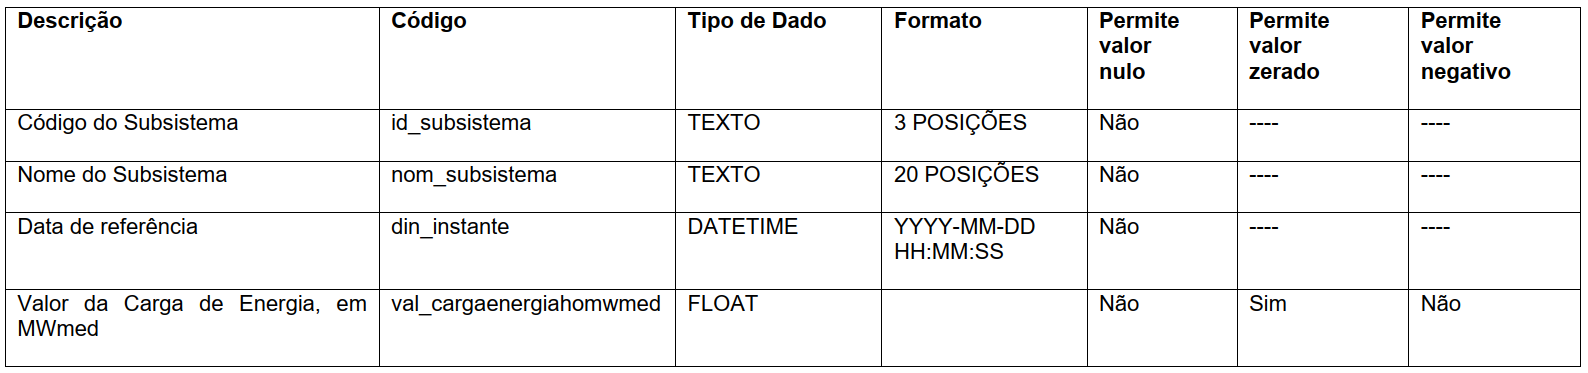


O objetivo do trabalho é treinar um modelo de machine learning para um problema de regressão, visando projetar, com base nos dados históricos, a carga de energia futura em base horária.

Este tipo de projeção é fundamental para um melhor planejamento da operação e da expansão do parque gerador de energia elétrica no país, além de impactar outras aplicações, como o preço spot de energia elétrica.


**2. Preparação dos dados**

Os dados foram baixados do site do ONS e carregados em um repositório no Github. Como os dados estão originalmente divididos em vários arquivos csv (um para cada ano), estes arquivos foram carregados a partir de uma lista de URLs e posteriormente concatenados em um único dataframe.

O dataset possui dados de carga de energia segregados em base horária e por subsistema, sendo que o sistema elétrico brasileiro é dividido em 4 subsistemas: Sudeste/Centro-Oeste, Sul, Nordeste e Norte.

Cabe ressaltar que cada subsistema possui características distintas no perfil de consumo de energia. De forma a simplicar o problema, tanto em termo de complexidade quanto de tempo de treinamento, o projeto utilizará apenas os dados do maior subsistema, o Sudeste/Centro-Oeste. Entende-se que esta estratégia está alinhada com o conceito de um MVP, e futuramente o projeto pode ser expandido para os demais subsistemas.

Dessa forma, foram excluídos os registros com os dados dos outros subsistemas que não serão utilizados. Assim, considerando que agora todos os registros referem-se a um único submercado, foram também excluídas as colunas id_subsistema e nom_subsistema, que não são mais relevantes.

In [ ]:
# Importação das bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV, train_test_split, TimeSeriesSplit, RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer, mean_absolute_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from prophet import Prophet
import shap


color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [ ]:
# Carregamento dos dados

# Define a lista de URLs para os arquivos CSV no repositório do GitHub
urls = [
  'https://raw.githubusercontent.com/ckessler01/Machine_Learning/refs/heads/main/CURVA_CARGA_2003.csv',
  'https://raw.githubusercontent.com/ckessler01/Machine_Learning/refs/heads/main/CURVA_CARGA_2004.csv',
  'https://raw.githubusercontent.com/ckessler01/Machine_Learning/refs/heads/main/CURVA_CARGA_2005.csv',
  'https://raw.githubusercontent.com/ckessler01/Machine_Learning/refs/heads/main/CURVA_CARGA_2006.csv',
  'https://raw.githubusercontent.com/ckessler01/Machine_Learning/refs/heads/main/CURVA_CARGA_2007.csv',
  'https://raw.githubusercontent.com/ckessler01/Machine_Learning/refs/heads/main/CURVA_CARGA_2008.csv',
  'https://raw.githubusercontent.com/ckessler01/Machine_Learning/refs/heads/main/CURVA_CARGA_2009.csv',
  'https://raw.githubusercontent.com/ckessler01/Machine_Learning/refs/heads/main/CURVA_CARGA_2010.csv',
  'https://raw.githubusercontent.com/ckessler01/Machine_Learning/refs/heads/main/CURVA_CARGA_2011.csv',
  'https://raw.githubusercontent.com/ckessler01/Machine_Learning/refs/heads/main/CURVA_CARGA_2012.csv',
  'https://raw.githubusercontent.com/ckessler01/Machine_Learning/refs/heads/main/CURVA_CARGA_2013.csv',
  'https://raw.githubusercontent.com/ckessler01/Machine_Learning/refs/heads/main/CURVA_CARGA_2014.csv',
  'https://raw.githubusercontent.com/ckessler01/Machine_Learning/refs/heads/main/CURVA_CARGA_2015.csv',
  'https://raw.githubusercontent.com/ckessler01/Machine_Learning/refs/heads/main/CURVA_CARGA_2016.csv',
  'https://raw.githubusercontent.com/ckessler01/Machine_Learning/refs/heads/main/CURVA_CARGA_2017.csv',
  'https://raw.githubusercontent.com/ckessler01/Machine_Learning/refs/heads/main/CURVA_CARGA_2018.csv',
  'https://raw.githubusercontent.com/ckessler01/Machine_Learning/refs/heads/main/CURVA_CARGA_2019.csv',
  'https://raw.githubusercontent.com/ckessler01/Machine_Learning/refs/heads/main/CURVA_CARGA_2020.csv',
  'https://raw.githubusercontent.com/ckessler01/Machine_Learning/refs/heads/main/CURVA_CARGA_2021.csv',
  'https://raw.githubusercontent.com/ckessler01/Machine_Learning/refs/heads/main/CURVA_CARGA_2022.csv',
  'https://raw.githubusercontent.com/ckessler01/Machine_Learning/refs/heads/main/CURVA_CARGA_2023.csv',

]

# Lista para armazenar os DataFrames carregados
df_list = []

# Loop para carregar cada arquivo CSV e armazenar no DataFrame
for url in urls:
    df = pd.read_csv(url, sep=';')
    df_list.append(df)

# Concatena todos os DataFrames em um único DataFrame
df_consolidado = pd.concat(df_list, ignore_index=True)

# Exibe informações do DataFrame consolidado (primeiras e últimas linhas e
# o total de linhas)
print(df_consolidado.head())
print(df_consolidado.tail())
print(f"Total de linhas: {len(df_consolidado)}")

  id_subsistema nom_subsistema         din_instante  val_cargaenergiahomwmed
0             N          NORTE  2003-01-01 00:00:00              2700.700000
1            NE       NORDESTE  2003-01-01 00:00:00              5707.450000
2             S            SUL  2003-01-01 00:00:00              6690.310004
3            SE        SUDESTE  2003-01-01 00:00:00             21092.869996
4             N          NORTE  2003-01-01 01:00:00              2648.200000
       id_subsistema nom_subsistema         din_instante  \
736223            SE        SUDESTE  2023-12-31 22:00:00   
736224             N          NORTE  2023-12-31 23:00:00   
736225            NE       NORDESTE  2023-12-31 23:00:00   
736226             S            SUL  2023-12-31 23:00:00   
736227            SE        SUDESTE  2023-12-31 23:00:00   

        val_cargaenergiahomwmed  
736223                38135.522  
736224                 6641.410  
736225                12144.917  
736226                10365.647  
736227 

In [ ]:
# Filtra apenas as linhas onde id_subsistema é "SE"
df_sudeste = df_consolidado[df_consolidado['id_subsistema'] == "SE"]

# Remove as colunas id_subsistema e nom_subsistema
df_sudeste = df_sudeste.drop(columns=['id_subsistema', 'nom_subsistema'])

# Exibe o DataFrame resultante
print(df_sudeste.head())

           din_instante  val_cargaenergiahomwmed
3   2003-01-01 00:00:00             21092.869996
7   2003-01-01 01:00:00             21448.520009
11  2003-01-01 02:00:00             21329.340009
15  2003-01-01 03:00:00             20672.369991
19  2003-01-01 04:00:00             20073.300010


Em seguida, foram removidas as linhas com valores nulos.

In [ ]:
# Tratamento de valores nulos
df_sudeste = df_sudeste.dropna(subset=['val_cargaenergiahomwmed'])  # Remove as linhas com NaN na variável dependente

# Verificar se há valores nulos restantes
print(df_sudeste.isnull().sum())

din_instante               0
val_cargaenergiahomwmed    0
dtype: int64


Com os dados já tratados, foi plotado um gráfico para visualização. Pode-se observar que a carga de energia possui uma tendência de crescimento ao longo dos anos, e possui algumas características de sazonalidade.

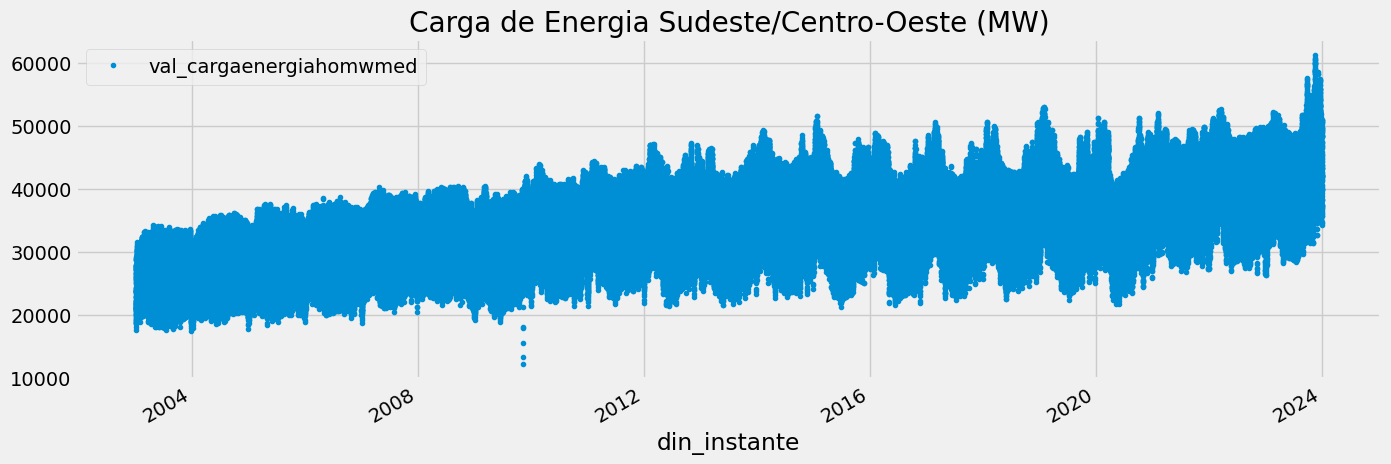

In [ ]:
df_sudeste = df_sudeste.set_index('din_instante')
df_sudeste.index = pd.to_datetime(df_sudeste.index)

df_sudeste.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='Carga de Energia Sudeste/Centro-Oeste (MW)')
plt.show()

Para enriquecer o modelo e capturar padrões sazonais, foram criadas algumas features.

In [ ]:
# Feature Engineering - Adicionando features temporais
df_sudeste['hour'] = df_sudeste.index.hour
df_sudeste['dayofweek'] = df_sudeste.index.dayofweek
df_sudeste['dayoyear'] = df_sudeste.index.dayofyear
df_sudeste['quarter'] = df_sudeste.index.quarter
df_sudeste['month'] = df_sudeste.index.month
df_sudeste['year'] = df_sudeste.index.year
df_sudeste['sin_hour'] = np.sin(2 * np.pi * df_sudeste.index.hour / 24)
df_sudeste['cos_hour'] = np.cos(2 * np.pi * df_sudeste.index.hour / 24)
df_sudeste['cumulative_load'] = df_sudeste['val_cargaenergiahomwmed'].cumsum()

print(df_sudeste.head())

                     val_cargaenergiahomwmed  hour  dayofweek  dayoyear  \
din_instante                                                              
2003-01-01 00:00:00             21092.869996     0          2         1   
2003-01-01 01:00:00             21448.520009     1          2         1   
2003-01-01 02:00:00             21329.340009     2          2         1   
2003-01-01 03:00:00             20672.369991     3          2         1   
2003-01-01 04:00:00             20073.300010     4          2         1   

                     quarter  month  year  sin_hour  cos_hour  cumulative_load  
din_instante                                                                    
2003-01-01 00:00:00        1      1  2003  0.000000  1.000000     21092.869996  
2003-01-01 01:00:00        1      1  2003  0.258819  0.965926     42541.390005  
2003-01-01 02:00:00        1      1  2003  0.500000  0.866025     63870.730013  
2003-01-01 03:00:00        1      1  2003  0.707107  0.707107     845

Em seguida, foram realizadas as seguintes etapas:

- Separação: Divide os dados em features (X) e variável alvo (y).

- Escalonamento: Normaliza os dados para que todas as features tenham a mesma escala, o que é importante para muitos algoritmos de machine learning.

- Divisão em Treino e Teste: Divide os dados em conjuntos de treinamento e teste, preservando a ordem temporal dos dados, o que é crucial para séries temporais.

In [ ]:
# Separando em variáveis dependente e independente
X = df_sudeste.drop(columns=['val_cargaenergiahomwmed'])
y = df_sudeste['val_cargaenergiahomwmed']

# Escalonamento
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Divisão em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

**3. Modelagem e Treinamento**

Foram selecionados alguns modelos que são adequados para o problema em questão: XGBoost, LightGBM, Random Forest e Linear Regression.

Justificativa para a Escolha dos Modelos:

XGBoost (Extreme Gradient Boosting): XGBoost é um dos algoritmos de aprendizado de máquina mais poderosos e eficientes para problemas de regressão e classificação. Ele é baseado em árvores de decisão e utiliza técnicas de boosting, onde múltiplas árvores são treinadas sequencialmente para corrigir os erros das árvores anteriores. É conhecido por sua alta performance e capacidade de lidar com grandes volumes de dados e complexidade. Ele pode capturar relações não lineares e interações entre features, além de ser robusto a overfitting devido a seus múltiplos parâmetros de regularização.

LightGBM (Light Gradient Boosting Machine): LightGBM é uma alternativa ao XGBoost, com foco em eficiência e velocidade. Ele é projetado para ser altamente eficiente em termos de memória e rápido no treinamento, especialmente com grandes conjuntos de dados. Utiliza técnicas de histogram-based decision tree learning, o que permite uma divisão mais rápida dos dados. Ele é eficaz em capturar padrões complexos e interações entre features, além de ser escalável e adequado para problemas de previsão em larga escala.

Random Forest: Random Forest é um ensemble de árvores de decisão que fornece robustez e estabilidade nas previsões. Ele constrói múltiplas árvores de decisão independentes e combina suas previsões para obter um resultado final.
É menos propenso a overfitting em comparação com árvores de decisão individuais, devido à sua técnica de bagging (bootstrap aggregating). Ele é capaz de capturar tanto relações lineares quanto não lineares e é resistente a outliers e a dados ruidosos.

Linear Regression: A regressão linear é um modelo estatístico simples e interpretável que assume uma relação linear entre as features e a variável alvo. É frequentemente usado como uma linha de base para comparação com modelos mais complexos. É fácil de implementar e interpretar. Ela fornece uma compreensão clara das contribuições de cada feature para a previsão da variável alvo. Em casos onde a relação entre as features e a variável alvo é aproximadamente linear, a regressão linear pode fornecer resultados rápidos e precisos.

A combinação desses modelos fornece uma abordagem abrangente para o problema de previsão de carga de energia, permitindo explorar diferentes técnicas de aprendizado de máquina. XGBoost e LightGBM são poderosos para capturar padrões complexos, enquanto Random Forest oferece robustez e estabilidade. A regressão linear serve como um modelo de linha de base interpretável, garantindo que a abordagem seja completa e bem fundamentada.

Também foi realizada a busca pelos melhores hiperparâmetros dos diferentes modelos utilizando RandomizedSearchCV, uma técnica de otimização de hiperparâmetros que avalia combinações aleatórias de parâmetros. O processo é ajustado especificamente para séries temporais usando TimeSeriesSplit, que respeita a natureza sequencial dos dados. Cabe ressaltar que algumas opções de hiperparâmetros foram reduzidas de forma a não comprometer o tempo de execução.

In [ ]:
# Definindo os modelos e parâmetros
models = {
    'XGBoost': xgb.XGBRegressor(),
    'LightGBM': lgb.LGBMRegressor(),
    'RandomForest': RandomForestRegressor(),
    'LinearRegression': LinearRegression()
}

param_grids = {
    'XGBoost': {
        'n_estimators': [25, 50],
        'max_depth': [3, 5],
        'learning_rate': [0.01, 0.1],
        'subsample': [0.7, 0.8],
        'colsample_bytree': [0.7, 0.8]
    },
    'LightGBM': {
        'n_estimators': [25, 50],
        'max_depth': [3, 5],
        'learning_rate': [0.01, 0.1],
        'subsample': [0.7, 0.8],
        'colsample_bytree': [0.7, 0.8]
    },
    'RandomForest': {
        'n_estimators': [25, 50],
        'max_depth': [3, 5],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
        'bootstrap': [True, False]
    },
    'LinearRegression': {}  # No hyperparameters to tune for LinearRegression
}

In [ ]:
# Realizando o RandomizedSearchCV com TimeSeriesSplit
best_models = {}
for model_name, model in models.items():
    param_dist = param_grids[model_name]
    tscv = TimeSeriesSplit(n_splits=5)  # Adjust n_splits as needed
    random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist,
                                       cv=tscv, n_jobs=-1, verbose=1, scoring='neg_mean_squared_error')
    random_search.fit(X_train, y_train)
    best_models[model_name] = random_search.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004390 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 617
[LightGBM] [Info] Number of data points in the train set: 147193, number of used features: 9
[LightGBM] [Info] Start training from score 32876.035369
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [ ]:
# Armazenar os modelos com os melhores hiperparâmetros encontrados
best_xgb = best_models['XGBoost']
best_lgbm = best_models['LightGBM']
best_rf = best_models['RandomForest']
best_lr = best_models['LinearRegression']

Os modelos foram então avaliados com a validação cruzada (k-fold).

In [ ]:
# Função para avaliar os modelos com k-fold cross-validation
def evaluate_model_kfold(model, X, y, cv=5):
    scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error')
    return np.sqrt(-scores)

In [ ]:
# Avaliar os modelos com os melhores parâmetros usando k-fold cross-validation
xgb_rmse_scores = evaluate_model_kfold(best_xgb, X_train, y_train)
lgbm_rmse_scores = evaluate_model_kfold(best_lgbm, X_train, y_train)
rf_rmse_scores = evaluate_model_kfold(best_rf, X_train, y_train)
lr_rmse_scores = evaluate_model_kfold(best_lr, X_train, y_train)

# Calcular as métricas médias para cada modelo
xgb_rmse_mean = xgb_rmse_scores.mean()
lgbm_rmse_mean = lgbm_rmse_scores.mean()
rf_rmse_mean = rf_rmse_scores.mean()
lr_rmse_mean = lr_rmse_scores.mean()

# Imprimir os resultados
print("RMSE médio (XGBoost):", xgb_rmse_mean)
print("RMSE médio (LightGBM):", lgbm_rmse_mean)
print("RMSE médio (Random Forest):", rf_rmse_mean)
print("RMSE médio (Linear Regression):", lr_rmse_mean)



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003508 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 614
[LightGBM] [Info] Number of data points in the train set: 117754, number of used features: 9
[LightGBM] [Info] Start training from score 34217.495384
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017917 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 615
[LightGBM] [Info] Number of data points in the train set: 117754, number of used features: 9
[LightGBM] [Info] Start training from score 33435.010516
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017300 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM

Observa-se que o modelo LightGBM apresentou o melhor resultado, considerando a métrica RMSE, porém o modelo XGBoost teve resultado similar. Já os modelos Random Forest e Linear Regression obteviveram um resultado pior.

Foi realizada também a comparação entre o desempenho dos modelos com os dados de treino e teste, considerando diferentes métricas (RMSE e MAE).

In [ ]:
# Avaliar os modelos com a base de teste
def calculate_metrics(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    return rmse, mae

test_metrics = {}
test_metrics['XGBoost'] = calculate_metrics(best_models['XGBoost'], X_test, y_test)
test_metrics['LightGBM'] = calculate_metrics(best_models['LightGBM'], X_test, y_test)
test_metrics['RandomForest'] = calculate_metrics(best_models['RandomForest'], X_test, y_test)
test_metrics['LinearRegression'] = calculate_metrics(best_models['LinearRegression'], X_test, y_test)

# Imprimir os resultados dos modelos com a base de teste
print("Desempenho dos Modelos na Base de Teste:")
for model_name, metrics in test_metrics.items():
    print(f"{model_name}: RMSE = {metrics[0]:.2f}, MAE = {metrics[1]:.2f}")

Desempenho dos Modelos na Base de Teste:
XGBoost: RMSE = 4218.63, MAE = 3372.69
LightGBM: RMSE = 4125.42, MAE = 3283.60
RandomForest: RMSE = 5317.37, MAE = 4319.26
LinearRegression: RMSE = 4911.52, MAE = 3927.75


De forma geral, o modelo LightGBM apresentou os melhores resultados. Destaca-se que há uma diferença significativa entre a performance dos modelos com os dados de treino e de teste. Uma possível causa seria o overfitting.

Entretanto, a diferença de performance ocorreu em todos os modelos testados. Uma possível causa para as diferenças poderia ser uma mudança no comportamento do consumidor de energia. Alguns fatores observados nos últimos anos podem estar impactando o consumo, como (i) maior acesso a aparelhos ar condicionado; (ii) carros elétricos; (iii) home office após a pandemia; (iv) maior ocorrência de temperaturas extremas.

Foram testados ainda dois modelos de emsembles, de forma a tentar obter melhores resultados.

In [ ]:
# Avaliar ensembles

# Definir os modelos base
models = [
    ('xgboost', best_models['XGBoost']),
    ('lightgbm', best_models['LightGBM']),
    ('random_forest', best_models['RandomForest'])
]

# Ensemble Voting Regressor
voting_ensemble = VotingRegressor(estimators=models)
voting_ensemble.fit(X_train, y_train)
test_metrics['Voting Ensemble'] = calculate_metrics(voting_ensemble, X_test, y_test)

# Stacking Ensemble
stacking_ensemble = StackingRegressor(
    estimators=models,
    final_estimator=Ridge(alpha=1.0)  # Meta-modelo
)
stacking_ensemble.fit(X_train, y_train)
test_metrics['Stacking Ensemble'] = calculate_metrics(stacking_ensemble, X_test, y_test)



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004506 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 617
[LightGBM] [Info] Number of data points in the train set: 147193, number of used features: 9
[LightGBM] [Info] Start training from score 32876.035369
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004587 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 617
[LightGBM] [Info] Number of data points in the train set: 147193, number of used features: 9
[LightGBM] [Info] Start training from score 32876.035369
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003656 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not

Por fim, foi adicionado o modelo Prophet. O Prophet é um modelo de série temporal desenvolvido pelo Facebook, projetado para lidar com dados que apresentam padrões sazonais complexos e tendências claras. Ele decompõe a série em componentes de tendência, sazonalidade e eventos, tornando-o altamente flexível e interpretável. Para o problema de previsão de carga de energia, que possui sazonalidades diárias, semanais e mensais, além de tendências de longo prazo, o Prophet é ideal por sua capacidade de capturar essas dinâmicas e fornecer previsões robustas e precisas.

In [ ]:
# Adicionar o modelo Prophet
df_prophet = df_sudeste.reset_index()[['din_instante', 'val_cargaenergiahomwmed']]
df_prophet.columns = ['ds', 'y']

# Separar treino e teste para o Prophet
train_prophet = df_prophet[df_prophet['ds'] < '2020-01-01']
test_prophet = df_prophet[df_prophet['ds'] >= '2020-01-01']

# Treinar o modelo Prophet
prophet_model = Prophet()
prophet_model.fit(train_prophet)

# Fazer previsões com o Prophet
future = prophet_model.make_future_dataframe(periods=len(test_prophet), freq='H')
forecast = prophet_model.predict(future)

# Avaliar o modelo Prophet
y_true = test_prophet['y'].values
y_pred = forecast['yhat'].values[-len(test_prophet):]

prophet_rmse = np.sqrt(mean_squared_error(y_true, y_pred))
prophet_mae = mean_absolute_error(y_true, y_pred)

test_metrics['Prophet'] = (prophet_rmse, prophet_mae)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp5gp5krsc/o17f_avk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5gp5krsc/t3biukns.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97269', 'data', 'file=/tmp/tmp5gp5krsc/o17f_avk.json', 'init=/tmp/tmp5gp5krsc/t3biukns.json', 'output', 'file=/tmp/tmp5gp5krsc/prophet_modelnoz5tsmd/prophet_model-20241212173212.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:32:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:35:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


**4. Avaliação de Resultados**

Nesta etapa, foi avaliado o desempenho dos modelos com dados não vistos, ou seja, com a base de teste.

As métricas RMSE (Root Mean Squared Error) e MAE (Mean Absolute Error) foram escolhidas para avaliar o desempenho dos modelos por suas características complementares na análise de erros:

RMSE: Mede a raiz quadrada da média dos erros ao quadrado, sendo mais sensível a grandes desvios entre os valores reais e previstos. Essa sensibilidade torna o RMSE útil para identificar situações em que grandes erros possam ter impacto significativo no problema analisado.

MAE: Mede a média dos erros absolutos, oferecendo uma visão direta da magnitude média dos desvios sem penalizar excessivamente grandes discrepâncias. Isso torna o MAE mais robusto contra outliers.

Essas métricas em conjunto permitem uma análise abrangente, balanceando sensibilidade a grandes erros e robustez para avaliar o desempenho geral dos modelos.

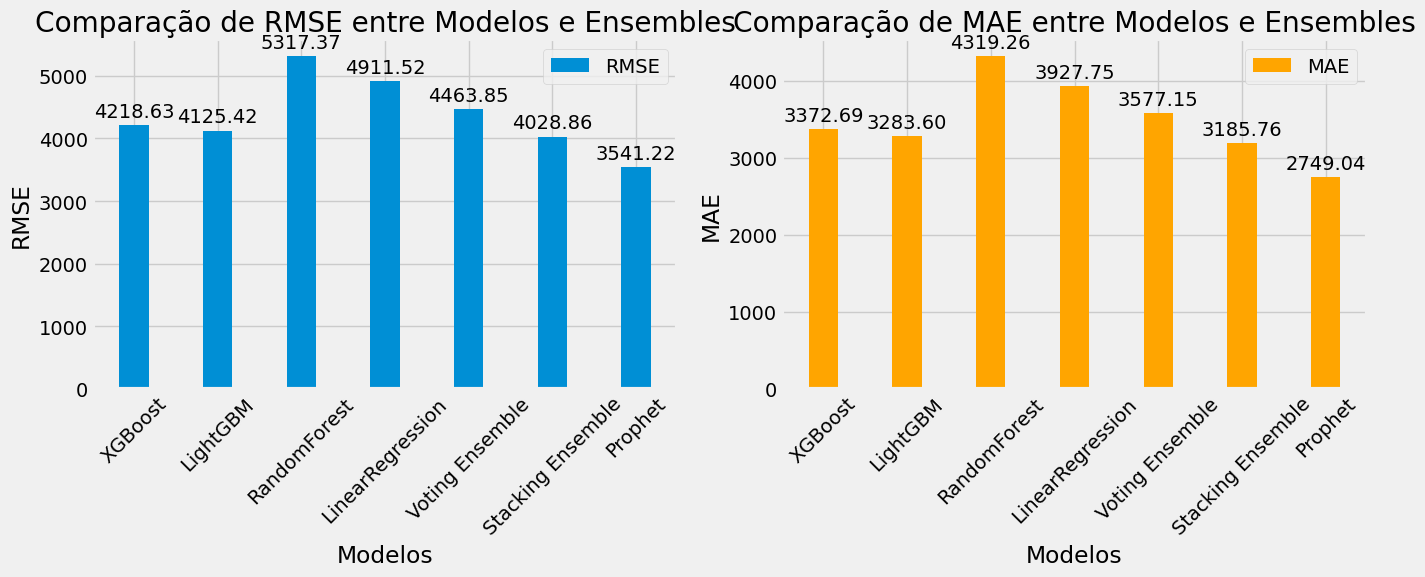

In [ ]:
# Preparar os dados para os gráficos
model_names = list(test_metrics.keys())
rmse_values = [metrics[0] for metrics in test_metrics.values()]
mae_values = [metrics[1] for metrics in test_metrics.values()]

# Configurações dos gráficos
x = np.arange(len(model_names))  # Localização das barras
width = 0.35  # Largura das barras

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Gráfico de RMSE
rmse_bars = ax1.bar(x, rmse_values, width, label='RMSE')
ax1.set_xlabel('Modelos')
ax1.set_ylabel('RMSE')
ax1.set_title('Comparação de RMSE entre Modelos e Ensembles')
ax1.set_xticks(x)
ax1.set_xticklabels(model_names, rotation=45)
ax1.legend()

# Adicionar os valores em cima das barras para melhor visualização
def add_labels(ax, bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points de deslocamento vertical
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(ax1, rmse_bars)

# Gráfico de MAE
mae_bars = ax2.bar(x, mae_values, width, label='MAE', color='orange')
ax2.set_xlabel('Modelos')
ax2.set_ylabel('MAE')
ax2.set_title('Comparação de MAE entre Modelos e Ensembles')
ax2.set_xticks(x)
ax2.set_xticklabels(model_names, rotation=45)
ax2.legend()

add_labels(ax2, mae_bars)

plt.tight_layout()
plt.show()

O modelo Prophet apresentou os melhores resultados, obtendo os menores valores de erro em ambas as métricas avaliadas (RMSE e MAE). Dessa forma, o modelo Prophet foi escolhido como melhor opção para o problema de projeção de carga de energia.

Por fim, foram plotados 2 gráficos comparando os resultados da predição com o melhor modelo (Prophet) com os dados realizados. O primeiro gráfico faz a comparação em todo o período de teste, enquanto o segundo mostra apenas um mês, de forma a visualizar melhor a sazonalidade horária.

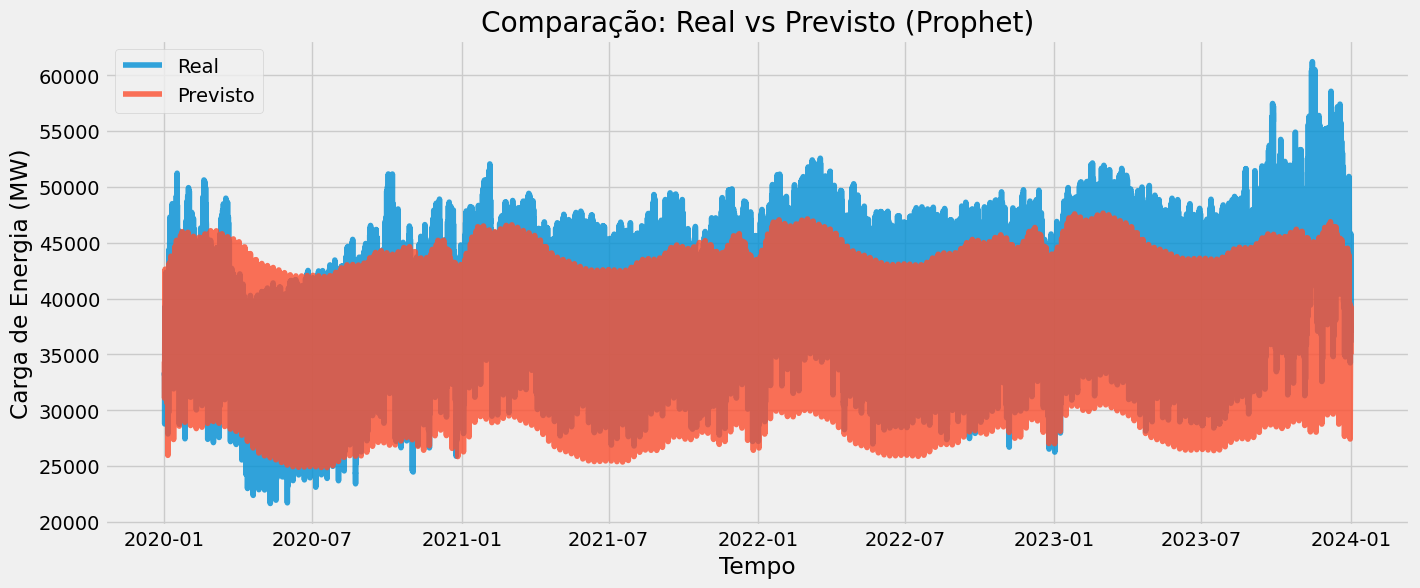

In [ ]:
# Gráfico comparando as predições do Prophet com os dados reais
plt.figure(figsize=(15, 6))
plt.plot(test_prophet['ds'], y_true, label='Real', color=color_pal[0], alpha=0.8)
plt.plot(test_prophet['ds'], y_pred, label='Previsto', color=color_pal[1], alpha=0.8)
plt.title('Comparação: Real vs Previsto (Prophet)')
plt.xlabel('Tempo')
plt.ylabel('Carga de Energia (MW)')
plt.legend()
plt.grid(True)
plt.show()

Analisando o gráfico acima, percebe-se que o modelo Prophet consegue capturar a sazonalidade mensal, bem como uma tendência de crescimento no longo prazo. Entretanto, os valores realizados foram maiores do que a predição em boa parte do período de teste.

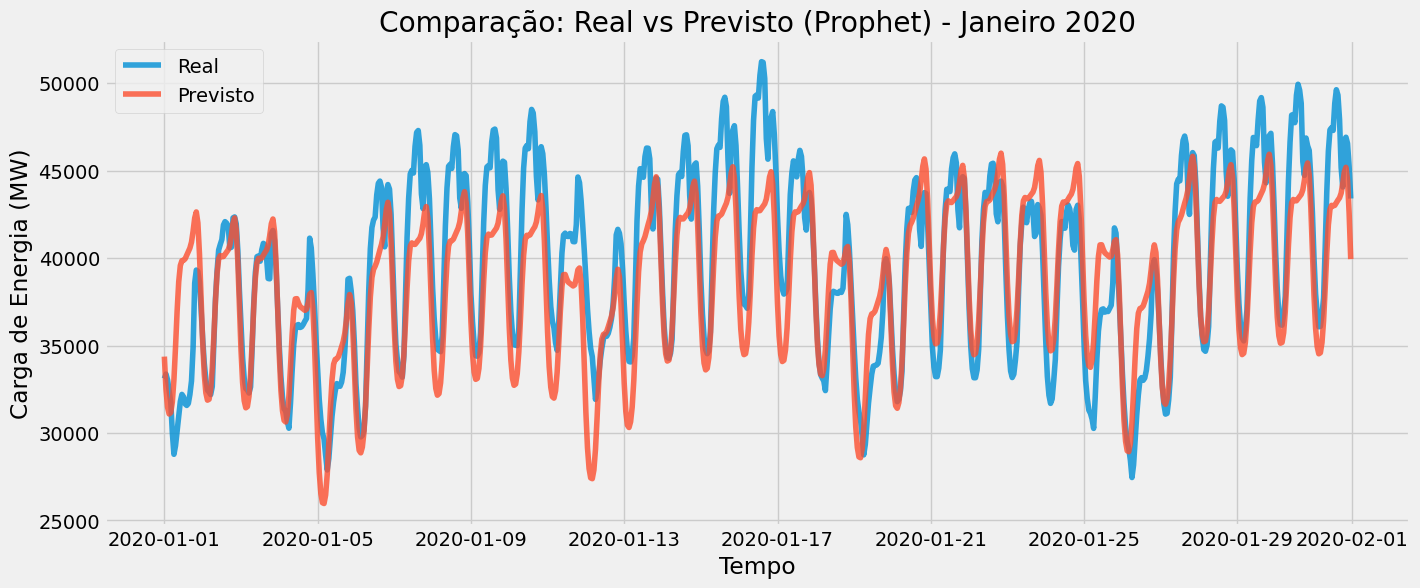

In [ ]:
# Focando em um mês específico (janeiro de 2020)
mask_jan_2020 = (test_prophet['ds'] >= '2020-01-01') & (test_prophet['ds'] < '2020-02-01')
test_prophet_jan_2020 = test_prophet[mask_jan_2020]
y_true_jan_2020 = test_prophet_jan_2020['y'].values
y_pred_jan_2020 = forecast.loc[forecast['ds'].isin(test_prophet_jan_2020['ds']), 'yhat'].values

plt.figure(figsize=(15, 6))
plt.plot(test_prophet_jan_2020['ds'], y_true_jan_2020, label='Real', color=color_pal[0], alpha=0.8)
plt.plot(test_prophet_jan_2020['ds'], y_pred_jan_2020, label='Previsto', color=color_pal[1], alpha=0.8)
plt.title('Comparação: Real vs Previsto (Prophet) - Janeiro 2020')
plt.xlabel('Tempo')
plt.ylabel('Carga de Energia (MW)')
plt.legend()
plt.grid(True)
plt.show()

Já no gráfico acima, em que é dado um foco em apenas um mês, podemos observar que o modelo também conseguiu capturar a sazonalidade horária típica do consumo de energia, com picos durante a tarde e início da noite e vales durante a madrugada. Da mesma forma, o modelo conseguiu modelar adequadamente as diferenças entre dias úteis e finais de semana.

Em resumo, entendo que o objetivo do trabalho foi plenamente alcançado. Foram testados diversos modelos, entre os quais o Prophet mostrou-se o mais adequado para o problema.

Ainda assim, há espaço para melhorias, de forma a tentar aprimorar as predições. Como sugestão de aperfeiçoamento do trabalho no futuro, pode-se adicionar outros dados que possam ajudar a explicar o comportamento da carga de energia, como temperatura e crescimento econômico.